#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
plt.style.use('ggplot')
import nltk

nlp = spacy.load('en_core_web_sm')

In [2]:
#loading the dataset
data = pd.read_csv('Reviews.csv') 

In [3]:
df = data.sample(500, random_state=42).reset_index()
df.shape

(500, 11)

BASIC NLTK FUNCTIONS

In [4]:
example = df.Text.values[50]
example

'With a legendary name like Gevalia, I was disappointed to find that the coffee contains artificial flavors.  The outside packaging looks gourmet and epicurean, with gold lettering.  Unfortunately, artificial flavoring also plainly occupies the front face.<br /><br />The aroma from the coffee is quite pleasant, however, after brewing, the coffee itself is nothing to write home about.  In fact, it tasted rather bitter.<br /><br />I would not buy this item.'

In [5]:
# tokenizing
tokens = nltk.word_tokenize(example)
tokens[:10]

['With',
 'a',
 'legendary',
 'name',
 'like',
 'Gevalia',
 ',',
 'I',
 'was',
 'disappointed']

In [6]:
# extracting parts of speech tags
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('With', 'IN'),
 ('a', 'DT'),
 ('legendary', 'JJ'),
 ('name', 'NN'),
 ('like', 'IN'),
 ('Gevalia', 'NNP'),
 (',', ','),
 ('I', 'PRP'),
 ('was', 'VBD'),
 ('disappointed', 'VBN')]

In [7]:
# Removing stop words and punctuations
doc = nlp(example)
clean_example = []
for token in doc:
    if token.is_stop or token.is_punct:
        continue
    clean_example.append(str(token))
    clean = ' '.join(clean_example)
print(clean)

legendary like Gevalia disappointed find coffee contains artificial flavors   outside packaging looks gourmet epicurean gold lettering   Unfortunately artificial flavoring plainly occupies face.<br /><br />The aroma coffee pleasant brewing coffee write home   fact tasted bitter.<br /><br />I buy item


### **ANALYSIS OF THE VADER MODEL**

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

intensity = sia.polarity_scores('Jeez, this stuff tastes kinda flat and a bit burned!, do better next time')
print(intensity)

{'neg': 0.0, 'neu': 0.79, 'pos': 0.21, 'compound': 0.4926}


In [10]:
# creating a dict- res, that contains the polarity scores for each Text with the row id as the index
res = {}

for i,j in tqdm(df.iterrows(), total=len(df)):
    text = j.Text
    id = j.Id
    
    res[id] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id','neg':'vader_neg','neu':'vader_neu','pos':'vader_pos','compound':'vader_compound'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,index,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,165257,0.000,0.768,0.232,0.9684,165256,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,0.089,0.766,0.144,0.7920,231465,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,0.000,0.880,0.120,0.4588,427827,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,0.009,0.827,0.163,0.9923,433954,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,0.089,0.719,0.191,0.9421,70260,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


Text(0, 0.5, 'Average VADER polarity score')

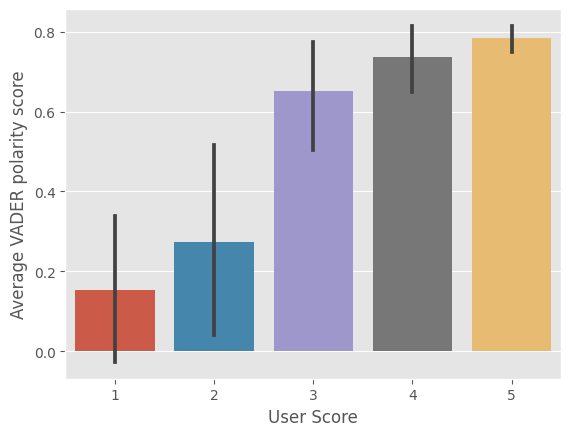

In [12]:
sns.barplot(data=vaders,x='Score', y='vader_compound' ) 
plt.xlabel('User Score')
plt.ylabel('Average VADER polarity score')

> Observation
> * The chart above shows the average polarity score by the user sentiment. This implies that the VADER model performs very well generally in classifying the sentiment of the reviews
___

#### **PERFORMANCE BY SENTIMENT**

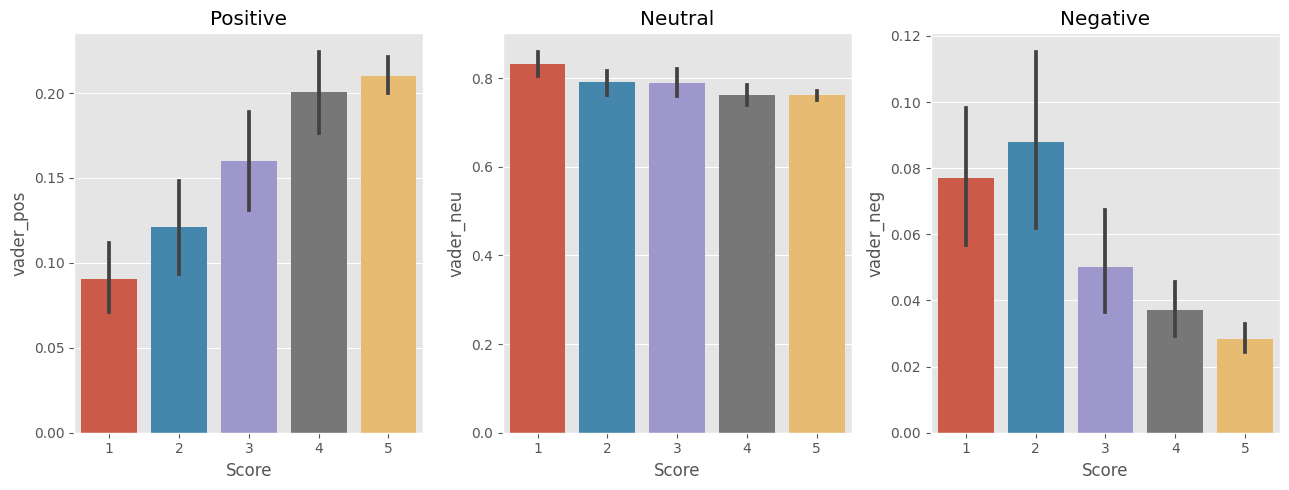

In [13]:
fig, ax = plt.subplots(1,3, figsize=(13,5))
sns.barplot(data=vaders, x='Score', y='vader_pos', ax=ax[0])
sns.barplot(data=vaders, x='Score', y='vader_neu', ax=ax[1])
sns.barplot(data=vaders, x='Score', y='vader_neg', ax=ax[2])
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()

**Inferences**
* The steady increase in the height of the bars shows that the positive vader scores increases as the user Score increases implying the VADER model performs fine
* The steady decrease in the height of the bars shows that the negative vader scores decreases as the user Score increases implying the VADER model performs fine in identifying negative sentiment
* The steady progression in the neutral scores shows neutrality through out the scores
___

## **ANALYSIS OF THE roBERTa MODEL**

* Uses a model trained on large corpus of data
* Transformer models accounts for the words but also the overall context of a word in a sentence

In [14]:
from transformers import AutoTokenizer # advanced tokenizer by hugging face
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax # smoothen the output between 0 and 1

A pretrained model by hugging face that has been trained on millions of labelled twitter comments, is used in this case

Transfer learning is utilized to pull the trained weights from the model

In [49]:
# the model is loaded from a local dir
model_path = r"C:\Users\HP\Documents\NLP\model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at C:\Users\HP\Documents\NLP\model were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
# Save the model and tokenizer to a directory
save_directory = r"C:\Users\HP\Documents\NLP\saved_model"
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

In [21]:
# A function that returns the sentiment probabilities on a text
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [52]:
encode_text = tokenizer('come again please', return_tensors='pt')
output = model(**encode_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'negative' : scores[0],
    'neutral' : scores[1],
    'positive' : scores[2]
}


{'negative': 0.03085825, 'neutral': 0.41175035, 'positive': 0.5573913}

In [60]:
max_key = max(scores_dict, key=scores_dict.get)
max_value = scores_dict[max_key]

'positive'

In [22]:
res = {}
for i, row in tqdm(vaders.iterrows(), total=len(vaders)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 184619
Broke for id 31994
Broke for id 171315
Broke for id 149020


In [23]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(vaders, how='left')

In [24]:
# lets drop the columns that are not helpful
results_df = results_df.drop(columns=['index', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator'])
results_df

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,Score,Time,Summary,Text
0,165257,0.006664,0.051202,0.942134,0.000,0.768,0.232,0.9684,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,0.012858,0.064116,0.923026,0.089,0.766,0.144,0.7920,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,0.674685,0.295431,0.029884,0.000,0.880,0.120,0.4588,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,0.077575,0.643972,0.278453,0.009,0.827,0.163,0.9923,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,0.008609,0.034906,0.956485,0.089,0.719,0.191,0.9421,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...
...,...,...,...,...,...,...,...,...,...,...,...,...
491,240528,0.014320,0.107624,0.878056,0.000,0.794,0.206,0.9296,5,1297987200,excellent sugar substitute,Xylitol looks and acts so much more like real ...
492,401662,0.201713,0.635300,0.162987,0.028,0.891,0.080,0.9447,5,1214352000,Lives up to its name,My grandpa used to tell stories about eating t...
493,321503,0.008396,0.024344,0.967260,0.234,0.601,0.165,-0.3187,5,1299024000,Great coffee!,"Very smooth, never bitter. Wonderful for me be..."
494,163041,0.043963,0.104653,0.851384,0.000,0.636,0.364,0.9849,4,1345939200,Great product...,"I really like this tea, but the bags are packe..."


In [25]:
results_df.to_csv('vader.csv', index=False)

In [26]:
data = pd.read_csv('vader.csv')
data.head()

,Id,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,Score,Time,Summary,Text
0,165257,0.006664,0.051202,0.942134,0.000,0.768,0.232,0.9684,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,0.012858,0.064116,0.923026,0.089,0.766,0.144,0.7920,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,0.674685,0.295431,0.029884,0.000,0.880,0.120,0.4588,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,0.077575,0.643972,0.278453,0.009,0.827,0.163,0.9923,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,0.008609,0.034906,0.956485,0.089,0.719,0.191,0.9421,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


In [27]:
data[data['Score'] <=3].sort_values('vader_pos', ascending=False).iloc[8]

Id                                                           280021
roberta_neg                                                0.906807
roberta_neu                                                0.078537
roberta_pos                                                0.014656
vader_neg                                                     0.124
vader_neu                                                     0.643
vader_pos                                                     0.233
vader_compound                                               0.6795
Score                                                             1
Time                                                     1233792000
Summary           very brittle, breaks much too easily, choking ...
Text              I was definately expecting a better product fr...
Name: 70, dtype: object

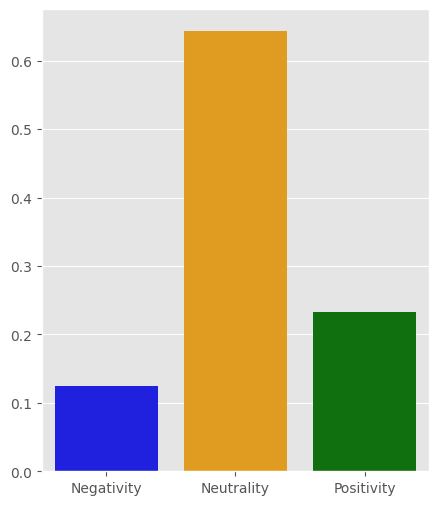

In [28]:
plt.figure(figsize=(5, 6))

# Define the data
x_labels = ['Negativity', 'Neutrality', 'Positivity']
y_values = [0.124, 0.643, 0.233]

# Create the bar plot
sns.barplot(x=x_labels, y=y_values, palette=['blue', 'orange', 'green'])
# Show the plot
plt.show()


In [29]:
data.shape

(496, 12)

## **BUILDING THE MODEL**

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, f1_score, recall_score

#### **ROBERTA MODEL**

In [32]:
roberta_x = data[['roberta_neg', 'roberta_neu', 'roberta_pos']]
roberta_y = data['Score']

In [33]:
roberta_x_train, roberta_x_test, roberta_y_train, roberta_y_test = \
    train_test_split(roberta_x, roberta_y, random_state=42, test_size=0.2)
    
print(roberta_x_train.shape)
print(roberta_x_test.shape)

(396, 3)
(100, 3)


In [34]:
random = RandomForestClassifier()
random.fit(roberta_x_train, roberta_y_train)
y_pred = random.predict(roberta_x_test)
print('f1_score: ', f1_score(roberta_y_test, y_pred, average='weighted'))
print('recall_score: ', recall_score(roberta_y_test, y_pred, average='weighted'))
print('precision_score: ', precision_score(roberta_y_test, y_pred, average='weighted'))

f1_score:  0.5992062836830638
recall_score:  0.65
precision_score:  0.5629497716894977


#### **VADER MODEL**

In [35]:
vader_x = data[['vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound']]
vader_y = data['Score']

In [36]:
vader_x_train, vader_x_test, vader_y_train, vader_y_test = train_test_split(vader_x, vader_y, random_state=42, test_size=0.2)
print(vader_x_train.shape)
print(vader_x_test.shape)

(396, 4)
(100, 4)


In [40]:
random = RandomForestClassifier()
random.fit(vader_x_train, vader_y_train)
y_pred = random.predict(vader_x_test)
print('f1_score: ', f1_score(vader_y_test, y_pred, average= 'weighted'))
print('recall_score: ', recall_score(vader_y_test, y_pred, average= 'weighted'))
print('precision_score: ', precision_score(vader_y_test, y_pred, average= 'weighted'))

f1_score:  0.5100675675675675
recall_score:  0.59
precision_score:  0.5109302325581395
